- Day 44 : 21/03/30
- https://www.kaggle.com/rhodiumbeng/classifying-multi-label-comments-0-9741-lb

# Classifying multi-label comments with Logistic Regression

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

## EDA

In [3]:
train_df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
127854,abe707b80ce5a097,"I didn't mean that, but you are being a real j...",1,0,0,0,1,0
81543,da1898b8c4b70e6f,"""\nYou remove that part by deleting the codes ...",0,0,0,0,0,0
96729,055a0a4ae29605d4,"According to Wikipedia:MOSISLAM, honourifics a...",0,0,0,0,0,0
32001,5505440406a4ac0c,"They were not actually OSes, because they requ...",0,0,0,0,0,0
80243,d6ae7dcadf7abcbf,that talk was preserved at any rate,0,0,0,0,0,0


이 training 데이터에서 코멘트는 toxic, severe toxic, obscene, threat, insult, identity hate의 6개 카테고리 중 한 개 이상으로 라벨링된다. 이는 본질적으로 다중 레이블 분류 문제다.

In [4]:
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

In [5]:
# 수치 열에 결측값 확인
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


결측 수치값이 없다. 평균 값이 매우 작기 때문에(0.05 이하), 6개 카테고리에서 양수로 표시되지 않는 경우가 많다. 이로부터 6개 카테고리 중 어느 카테고리에도 라벨링되지 않은 코멘트가 많다고 추측할 수 있다. 확인해보자.

In [7]:
unlabelled_in_all = train_df[(train_df['toxic']!=1) & (train_df['severe_toxic']!=1) & (train_df['obscene']!=1) 
                             & (train_df['threat']!=1) & (train_df['insult']!=1) & (train_df['identity_hate']!=1)]
print('Percentage of unlabelled comments is', len(unlabelled_in_all) / len(train_df)*100)

Percentage of unlabelled comments is 89.83211235124176


In [9]:
# 'null' 코멘트 확인
no_comment = train_df[train_df['comment_text'].isnull()]
len(no_comment)

0

In [10]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [11]:
no_comment = test_df[test_df['comment_text'].isnull()]
no_comment

,id,comment_text


train, test 데이터의 모든 행이 코멘트를 포함하므로, null 필드를 처리하지 않아도 된다.

In [12]:
# train, test 데이터의 총 행과 카테고리 수 확인
print('Total rows in test is {}'.format(len(test_df)))
print('Total rows in train is {}'.format(len(train_df)))
print(train_df[cols_target].sum())

Total rows in test is 153164
Total rows in train is 159571
obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


앞서 언급했듯이, train 데이터에서 대부분의 코멘트는 이 카테고리들 중 한 개 이상으로 레이블링되어있지 않다.

In [13]:
# train 데이터에서 행의 문자열 길이를 확인하고 기록
train_df['char_length'] = train_df['comment_text'].apply(lambda x: len(str(x)))

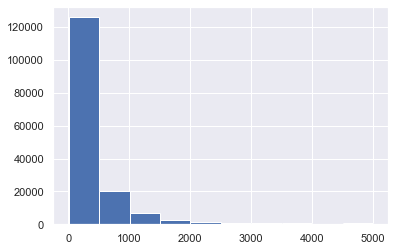

In [14]:
# 텍스트 길이의 히스토그램
sns.set()
train_df['char_length'].hist()
plt.show()

대부분의 텍스트 길이는 500자 이내이고 일부는 5000자 이상도 된다.

다음으로 target 변수간 상관관계를 살펴보자.

In [15]:
data = train_df[cols_target]